### Module import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline



### 1. Image Calibration

#### Created a user-defined function for distorted and undistorted images

In [98]:
def image_calib(nx, ny, i):
    '''
    nx is the number of the intersection of chess in x direction 
    ny is the number of the intersection of chess in y direction
    i is the ith image to be calibrated
    '''
    Path = './camera_cal/'
    
    objpoints = [] #3D dimension object, where z is the depth, index of chess board intersection, like (0,0,0), (1,0,0)...()
    imgpoints = [] #this is 2D image object, the coordinates of the distorted images for each index points
    
    objp = np.zeros((ny*nx,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    cal1 = Path + f'calibration{i}.jpg'
    
    image = cv2.imread(cal1)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret1, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret1 == True:
        objpoints.append(objp)
    # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret1)
        imgpoints.append(corners)
        #fig = plt.figure(figsize=(15,10))
        #fig.add_subplot(131)
        #plt.title(f'Distorted image{i}')
        #plt.imshow(img)
    else:
        print('Error: Corners NOT Found!!')
        return ret
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #fig.add_subplot(132)
    #plt.title('Undistorted image')
    #plt.imshow(undist)
    
    #cv2.drawChessboardCorners(undist, (nx, ny), corners, ret1)
    offset = 75 # offset for dst points
    
    # x coordinate first, then y
    img_size = (gray.shape[1], gray.shape[0])
    
    
    # top left-> top right->bottom right->bottom left
    src = np.float32([corners[0], corners[nx-2], corners[-2], corners[-nx]])
    
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    #fig.add_subplot(133)
    #plt.title('warped image')
    #plt.imshow(warped)
    return mtx, dist

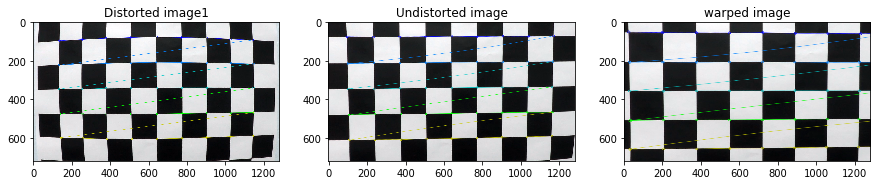

In [133]:
## The frist image has ny = 5, so display it seperately. Other calibration images have nx =9, and ny =6. 
image_calib(9,5,1)

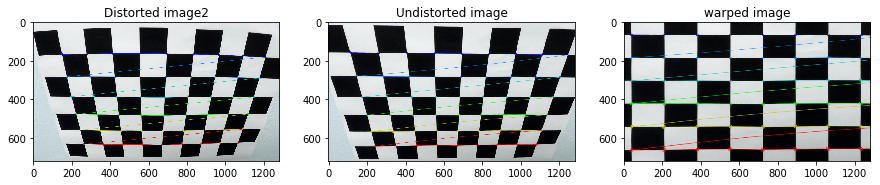

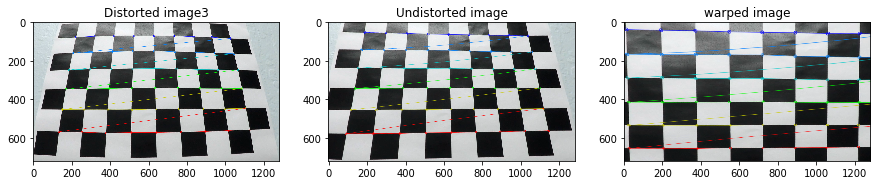

In [134]:
for i in range(2,4):
    image_calib(9,6,i)

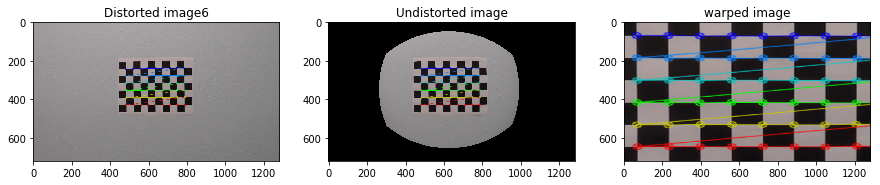

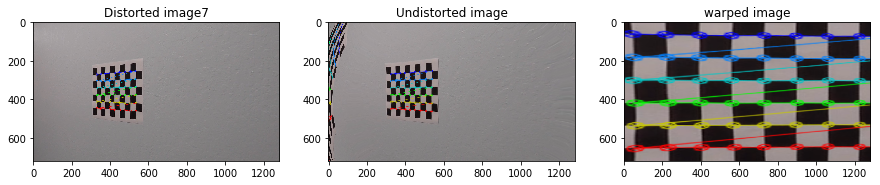

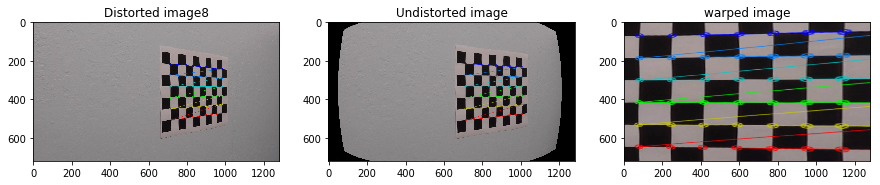

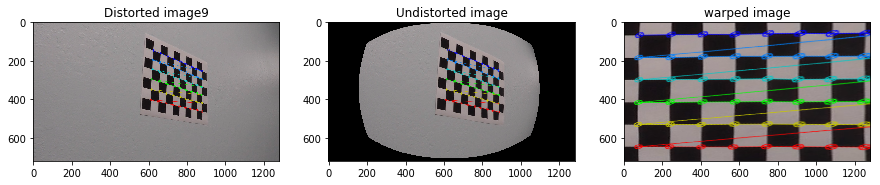

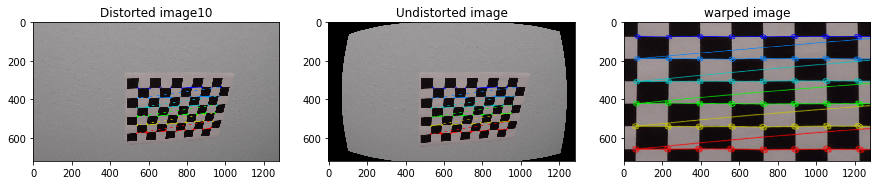

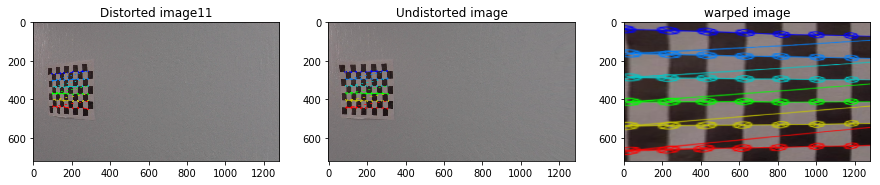

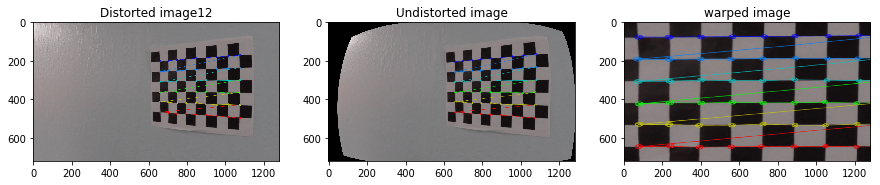

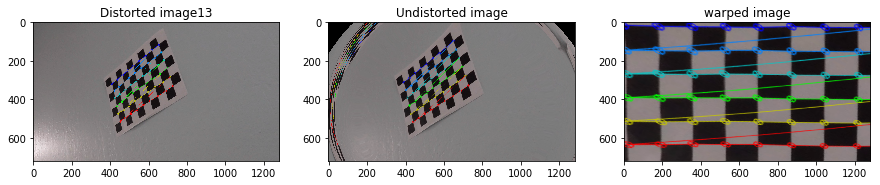

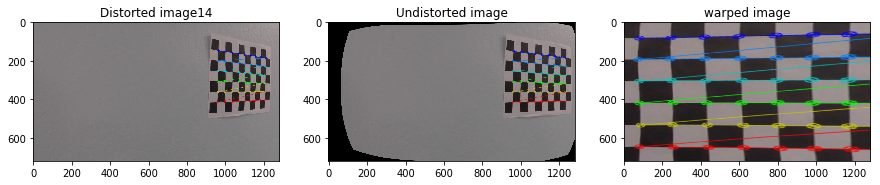

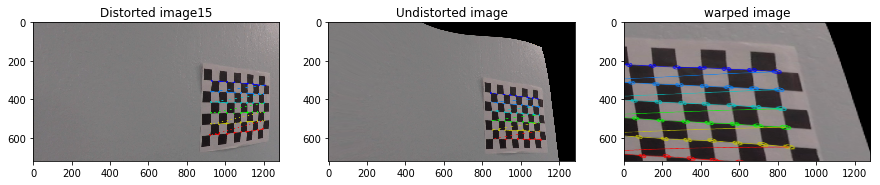

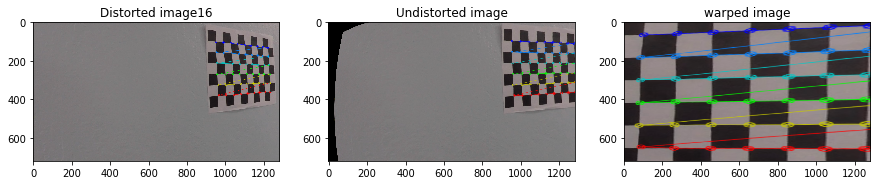

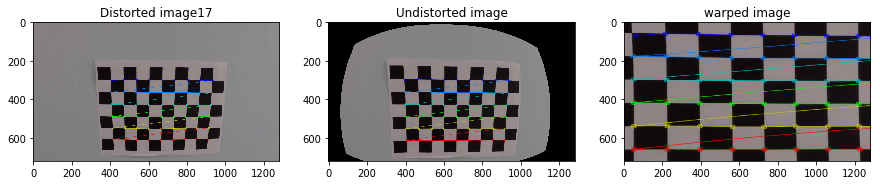

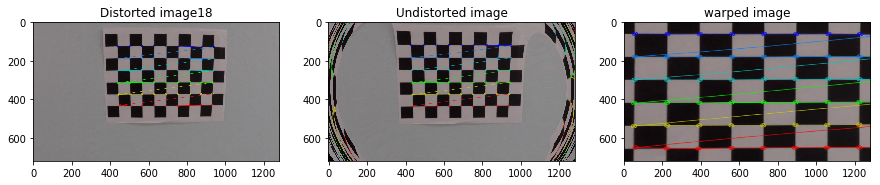

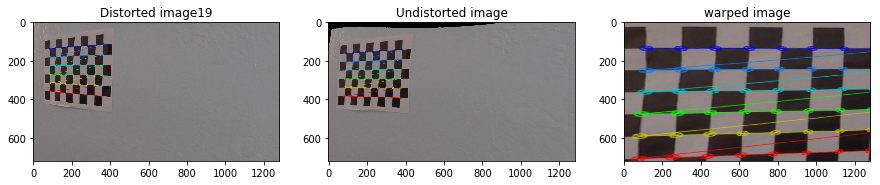

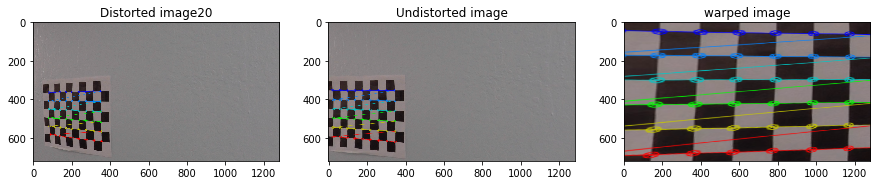

In [135]:
for i in range(6,21):
    image_calib(9,6,i)

(45, 3)
(45, 1, 2)


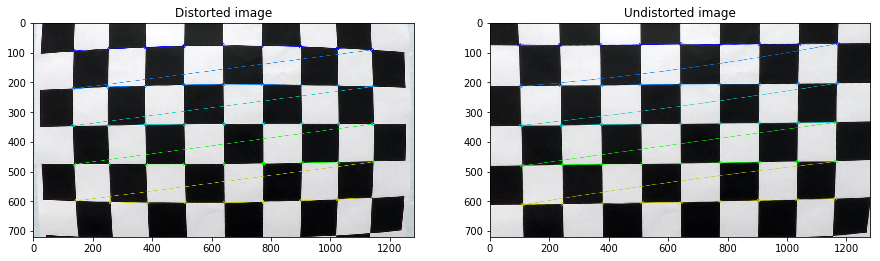

In [57]:
Path = './camera_cal/'
nx = 9  
ny = 5 

objpoints = [] #3D dimension object, where z is the depth, index of chess board intersection, like (0,0,0), (1,0,0)...()
imgpoints = [] #this is 2D image object, the coordinates of the distorted images for each index points

## I spent a lot of time in understanding the dimensions of 3D object points and 2D image points
objp = np.zeros((5*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
cal1 = Path + 'calibration1.jpg'

# Make a list of calibration images
img = cv2.imread(cal1)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print(objp.shape)
print(corners.shape)
# If found, draw corners
if ret == True:
    objpoints.append(objp)
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    imgpoints.append(corners)
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(121)
    plt.title('Distorted image')
    plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(122)
plt.title('Undistorted image')
plt.imshow(dst)

### Apply Sobel Operators to the images

##### The process is described briefly below:

1. Convert a colored image to gray
2. Apply Sobel operator to the gray image
3. Because Sobel operators applied, values of some pixels in the image were negative, which did not have much meanings in the context of a gray image. Therefore they were converted to positive values by apply abs function. 
4. In order to make the gradient image more clearly, use 1 to the pixel that are likely to be edges, and use 0 for the rest. 
5. Apply direction of the gradient to the image. 

Conclusion: even applied these processings, the lane lines of test1, test4, and test5 images were not well detected. By observing those images, we found they shared similiaries: shadows, strong sunlight, and color of the road surface. Therefore, other more processings, probably color processing, are needed for those images. 

##### HLS color processing:

After applying HLS color space, the lane lines were clearly detected regardless of shadow or sun light. 

In [81]:
def hls_threshold(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

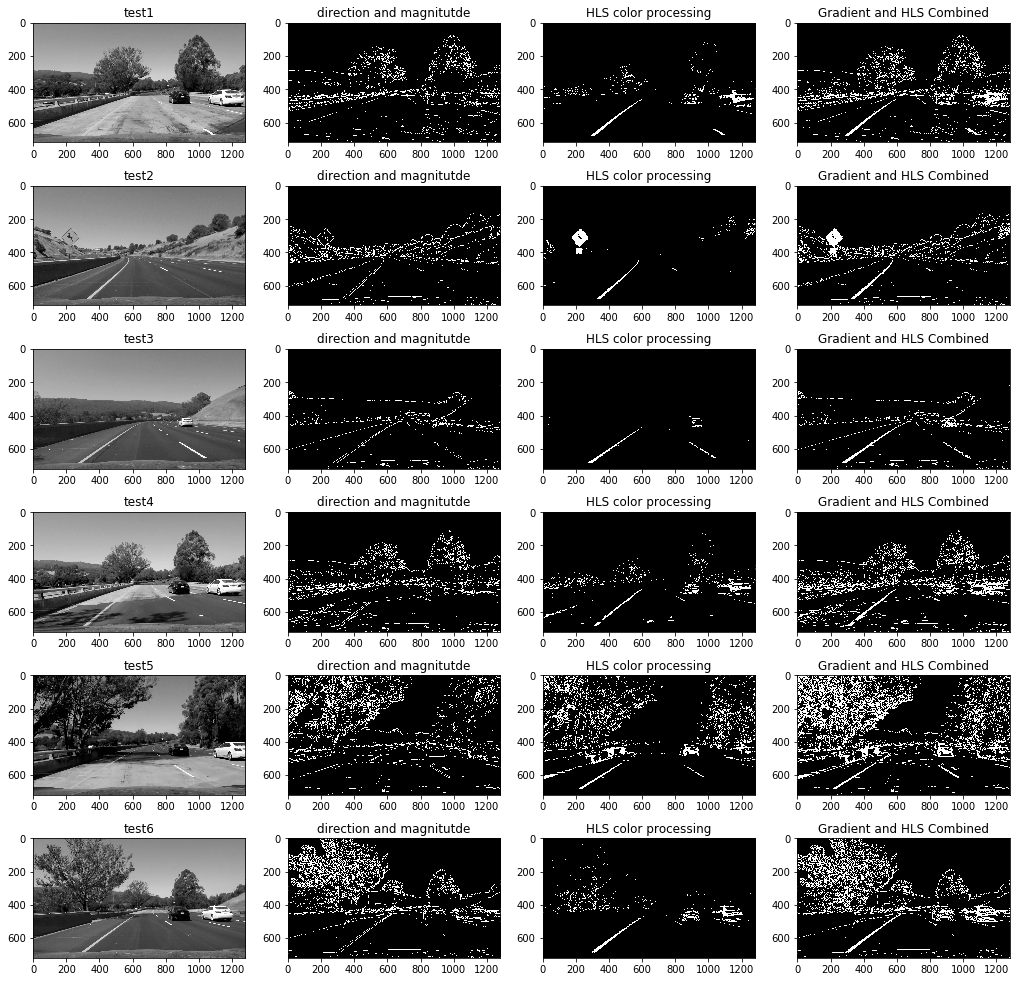

In [86]:
image_path = './test_images/'
fig = plt.figure(figsize=(17.5,17.5))

threshold1 = 35
threshold2 = 100

thresh1 = 0
thresh2 = np.pi/2
#testimg = []
for i in range(1,7):
    img = cv2.imread(image_path + f'test{i}.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    hls = hls_threshold(img,thresh=(150, 255))
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=3)
    #testimg.append(gray)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    angel = np.arctan2(abs_sobely, abs_sobelx)
    direction =  np.zeros_like(angel)
    direction[(angel >= thresh1) & (angel <= thresh2)] = 1
    
    sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scale = np.max(sobelxy)/255
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobelxy = np.uint8(sobelxy/scale)
    
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= threshold1) & (scaled_sobelx <= threshold2)] = 1
    
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= threshold1) & (scaled_sobely <= threshold2)] = 1

    sxybinary = np.zeros_like(sobelxy)
    sxybinary[(sobelxy >= threshold1) & (sobelxy <= threshold2)] = 1
    
    combined = np.zeros_like(sobelxy)
    
    combined[((sxybinary == 1) & (direction == 1))|((sxbinary == 1) & (sybinary == 1))] = 1
    
    final = np.zeros_like(sobelxy)
    
    final[(combined == 1) | (hls == 1)] = 1
    
    fig.add_subplot(6,4,(i-1)*4+1)
    plt.title(f'test{i}')
    plt.imshow(gray, cmap = 'gray')
    
    fig.add_subplot(6,4,(i-1)*4+2)
    plt.title('direction and magnitutde')
    plt.imshow(combined, cmap = 'gray')
    
    fig.add_subplot(6,4,(i-1)*4+3)
    plt.title('HLS color processing')
    plt.imshow(hls, cmap = 'gray') 
    
    fig.add_subplot(6,4,(i-1)*4+4)
    plt.title('Gradient and HLS Combined')
    plt.imshow(final, cmap = 'gray')   

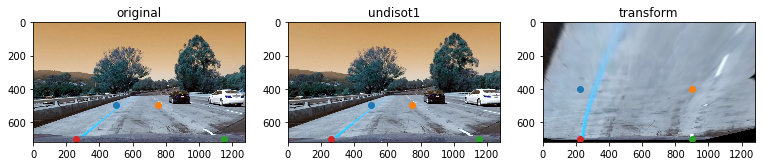

In [116]:
fig = plt.figure(figsize=(17.5,17.5))

mtx, dist = image_calib(9,5,1)
test1 = './test_images/test1.jpg'
img1 = cv2.imread(test1)

undist1 = cv2.undistort(img1, mtx, dist, None, mtx)

fig.add_subplot(6,4,(i-1)*4+1)
plt.plot(500,500,'o')
plt.plot(750,500,'o')
plt.plot(1150,700,'o')
plt.plot(260,700,'o')
plt.title('original')

plt.imshow(img1, cmap = 'gray')

fig.add_subplot(6,4,(i-1)*4+2)
plt.title('undisot1')
plt.plot(500,500,'o')
plt.plot(750,500,'o')
plt.plot(1150,700,'o')
plt.plot(260,700,'o')
plt.imshow(undist1, cmap = 'gray')

# x coordinate first, then y
img_size = (img1.shape[1], img1.shape[0])
    

# top left-> top right->bottom right->bottom left
src = np.float32([(500,500), (750,500), (1150,700), (260,700)])
    
dst = np.float32([(225,400), (900,400), (900,700), (225,700)])
    
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist1, M, img_size)


fig.add_subplot(6,4,(i-1)*4+3)
plt.title('transform')
plt.plot(225,400,'o')
plt.plot(900,400,'o')
plt.plot(900,700,'o')
plt.plot(225,700,'o')
plt.imshow(warped, cmap = 'gray')